In [46]:
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)
data_set = pd.read_csv("encod_dataset_2010_20_eval.csv")
data_set = data_set.dropna()
data_set = data_set.drop(columns = [ "First Payment Date", "Postal Code"])
data_set['Delinquent'] = data_set['Delinquent'].astype(int)
print(data_set.info())

# exclude outliers
len_before = data_set.size
data_set = data_set[(np.abs(stats.zscore(data_set[["Credit Score","Original Debt-to-Income (DTI) Ratio", "Original Loan-to-Value (LTV)"]])) < 3).all(axis = 1)]
print("removed {} outliers".format(len_before-data_set.size))
X_data = data_set[['Credit Score']]
X_data = data_set.drop(columns = ["Delinquent"])
y_data = data_set["Delinquent"].astype(int)
data_set["Delinquent"].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87359 entries, 0 to 87358
Data columns (total 73 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Delinquent                           87359 non-null  int32  
 1   Credit Score                         87359 non-null  float64
 2   First Time Homebuyer Flag            87359 non-null  int64  
 3   Number of Units                      87359 non-null  int64  
 4   Original Debt-to-Income (DTI) Ratio  87359 non-null  float64
 5   Original Loan-to-Value (LTV)         87359 non-null  float64
 6   Original Loan Term                   87359 non-null  int64  
 7   Number of Borrowers                  87359 non-null  int64  
 8   First Payment Year                   87359 non-null  int64  
 9   Occupancy Status_P                   87359 non-null  int64  
 10  Occupancy Status_S                   87359 non-null  int64  
 11  Channel_B                   

0    50917
1    35607
Name: Delinquent, dtype: int64

### Computing Performance Metrics of a Model

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_performance_metrics(test_y, pred):
    '''
    Computes the following performance metrics and returns them in the same order: F1, Accuracy, Recall, Precision.
    '''
    f1 = f1_score(test_y, pred)
    acc = accuracy_score(test_y, pred)
    rec = recall_score(test_y, pred)
    prec = precision_score(test_y, pred)

    balanced_acc = balanced_accuracy_score(test_y, pred)

    return f1, acc, rec, prec, balanced_acc



def confMat(true_labels, predicted_labels, visualize = False):
    '''
    Compute the confusion matrix given true labels and a prediction. Will also plot the matrix wenn visualize is set to "True".
    '''    
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(conf_mat)
    if visualize:    
        disp.plot(values_format='.4g', cmap='Greens')
        plt.show()

    return conf_mat


In [48]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.svm import SVC,LinearSVC

def evaluate_algo_performance(X_data, y_data, nr_splits = 10):
    '''
    Evaluate the mean and standard deviation of the performances of a mode over 10 folds of the dataset.
    Specify your own classification algorithm by replacing the logistic regression in step 2.
    '''
    k_fold = KFold(n_splits=nr_splits, shuffle=True, random_state=42)

    scores = {}
    scores["F1"] = []
    scores["Accuracy"] = []
    scores["Recall"] = []
    scores["Precision"] = []
    scores["Balanced Accuracy"] = []
    scores["Confusion Matrix"] = [[0, 0], [0, 0]]

    for train_index, test_index in k_fold.split(X=X_data, y=y_data):

        # 1. Load this iterations train and test data split
        train_X = X_data.iloc[train_index]
        train_y = y_data.iloc[train_index]
        test_X =X_data.iloc[test_index]
        test_y = y_data.iloc[test_index]

        # 1.2 normalize the data
        X_normalizer = preprocessing.StandardScaler().fit(train_X)
        train_X_normalized = X_normalizer.transform(train_X)
        train_X_normalized_df = pd.DataFrame(train_X_normalized, columns = train_X.columns)
        test_X_normalized = X_normalizer.transform(test_X)
        test_X_normalized_df = pd.DataFrame(test_X_normalized, columns = test_X.columns)

        # 2. train your model on this specific train/test split
        # -- INSERT YOUR MODEL HERE -- 
        logistic_reg = LogisticRegression()
        logistic_reg.fit(train_X_normalized_df, train_y)
        pred = logistic_reg.predict(test_X_normalized_df)
        # -- NEED VAR CALLED "PRED" WITH THE PREDICTIONS FOR THIS test_X --

        # 3. evaluating the performance of the model 
        f1, acc, rec, prec, balanced_acc = compute_performance_metrics(test_y, pred)
        scores["F1"].append(f1)
        scores["Accuracy"].append(acc)
        scores["Recall"].append(rec)
        scores["Precision"].append(prec)
        scores["Balanced Accuracy"].append(balanced_acc)

        conf_mat = confMat(true_labels=test_y, predicted_labels=pred, visualize=False)
        scores["Confusion Matrix"][0] += conf_mat[0]
        scores["Confusion Matrix"][1] += conf_mat[1]

    # 5. Compute the mean and standarddiviation of the models performances
    F1_mean = np.mean(np.asarray(scores["F1"]))
    F1_std = np.std(np.asarray(scores["F1"]))
    Acc_mean = np.mean(np.asarray(scores["Accuracy"]))
    Acc_std = np.std(np.asarray(scores["Accuracy"]))
    Rec_mean = np.mean(np.asarray(scores["Recall"]))
    Rec_std = np.std(np.asarray(scores["Recall"]))
    Prec_mean = np.mean(np.asarray(scores["Precision"]))
    Prec_std = np.std(np.asarray(scores["Precision"]))
    BalAcc_mean = np.mean(np.asarray(scores["Balanced Accuracy"]))
    BalAcc_std = np.std(np.asarray(scores["Balanced Accuracy"]))


    print(f"Accuracy mean:\t {round(100*Acc_mean, 2)}%")
    print(f"Accuracy std:\t {round(100*Acc_std, 2)}%")
    print(f"Bal Acc mean:\t {round(100*BalAcc_mean, 2)}%")
    print(f"Bal Acc std:\t {round(100*BalAcc_std, 2)}%")
    print(f"Precision mean:\t {round(100*Prec_mean, 2)}%")
    print(f"Precision std:\t {round(100*Prec_std, 2)}%")
    print(f"Recall mean:\t {round(100*Rec_mean, 2)}%")
    print(f"Recall std:\t {round(100*Rec_std, 2)}%")
    print(f"F1 mean:\t {round(100*F1_mean, 2)}%")
    print(f"F1 std:\t\t {round(100*F1_std, 2)}%")
    # compute average confusion matrix
    scores["Confusion Matrix"][0] = scores["Confusion Matrix"][0] / nr_splits
    scores["Confusion Matrix"][1] = scores["Confusion Matrix"][1] / nr_splits
    disp = ConfusionMatrixDisplay(np.asarray(scores["Confusion Matrix"]))
    disp.plot(values_format='.4g', cmap='Greens')
    plt.show()
    plt.savefig('conf_matrix_sgd.png')

    return scores

Accuracy mean:	 66.44%
Accuracy std:	 0.35%
Bal Acc mean:	 63.57%
Bal Acc std:	 0.4%
Precision mean:	 62.11%
Precision std:	 0.72%
Recall mean:	 47.31%
Recall std:	 0.77%
F1 mean:	 53.71%
F1 std:		 0.65%


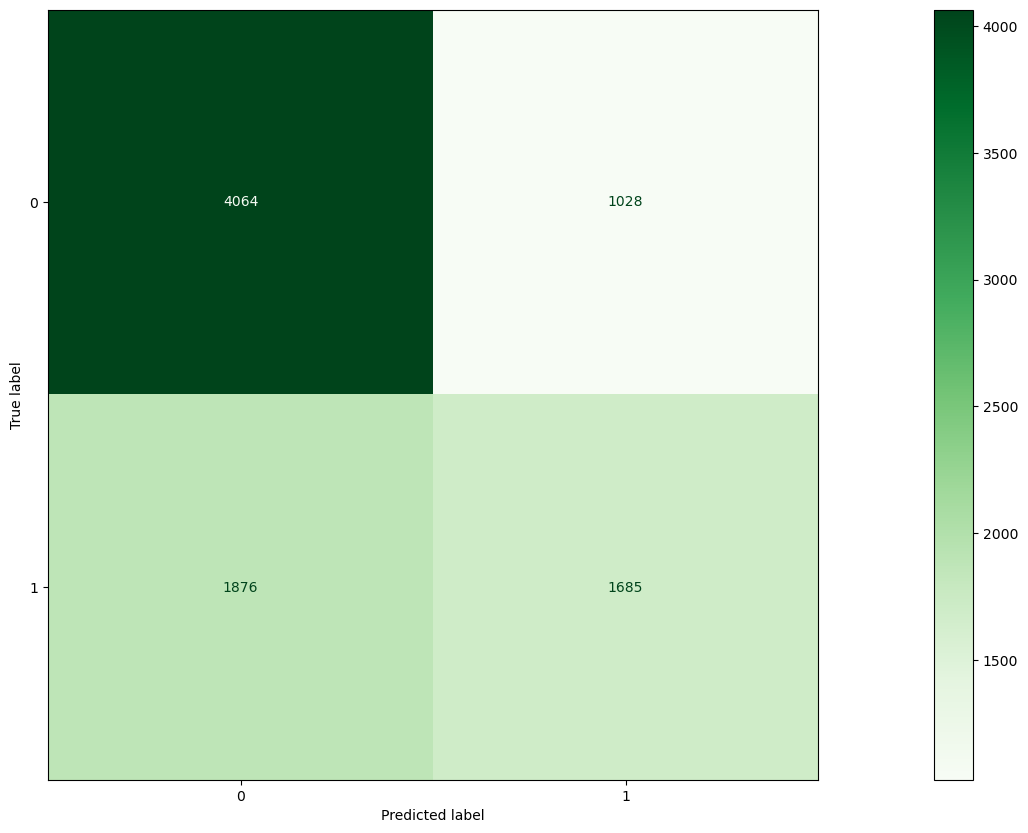

<Figure size 3000x1000 with 0 Axes>

In [49]:
perf_dict = evaluate_algo_performance(X_data, y_data, nr_splits=10)

### Retrieving the most important features for this model

In [50]:
# normalize the data
X_normalizer = preprocessing.StandardScaler().fit(X_data)
train_X_normalized = X_normalizer.transform(X_data)
train_X_normalized_df = pd.DataFrame(train_X_normalized, columns = X_data.columns)
feature_names = X_data.columns

# train your model
# -- INSERT YOUR MODEL HERE -- 
logistic_reg = LogisticRegression() # LogisticRegression(max_iter = 3000, penalty='none', solver='lbfgs')
logistic_reg.fit(train_X_normalized_df, y_data)

# extracting the features importance
feature_importance = logistic_reg.coef_[0]

In [51]:
# filter the most important features by their significance 
pick_best = 10
feature_importance_list = sorted(zip(feature_importance, feature_names), key=lambda x: abs(x[0]), reverse=True)
top_picks = [(round(imp, 3), name) for imp, name in feature_importance_list][:pick_best]
var_just_for_show = [print(tup) for tup in top_picks]


(-0.599, 'Credit Score')
(0.255, 'Channel_T')
(-0.24, 'Number of Borrowers')
(0.177, 'Original Debt-to-Income (DTI) Ratio')
(0.135, 'Property State_NY')
(0.121, 'Property State_FL')
(0.091, 'Property State_TX')
(0.088, 'Property State_NJ')
(-0.084, 'Occupancy Status_P')
(0.071, 'Original Loan Term')


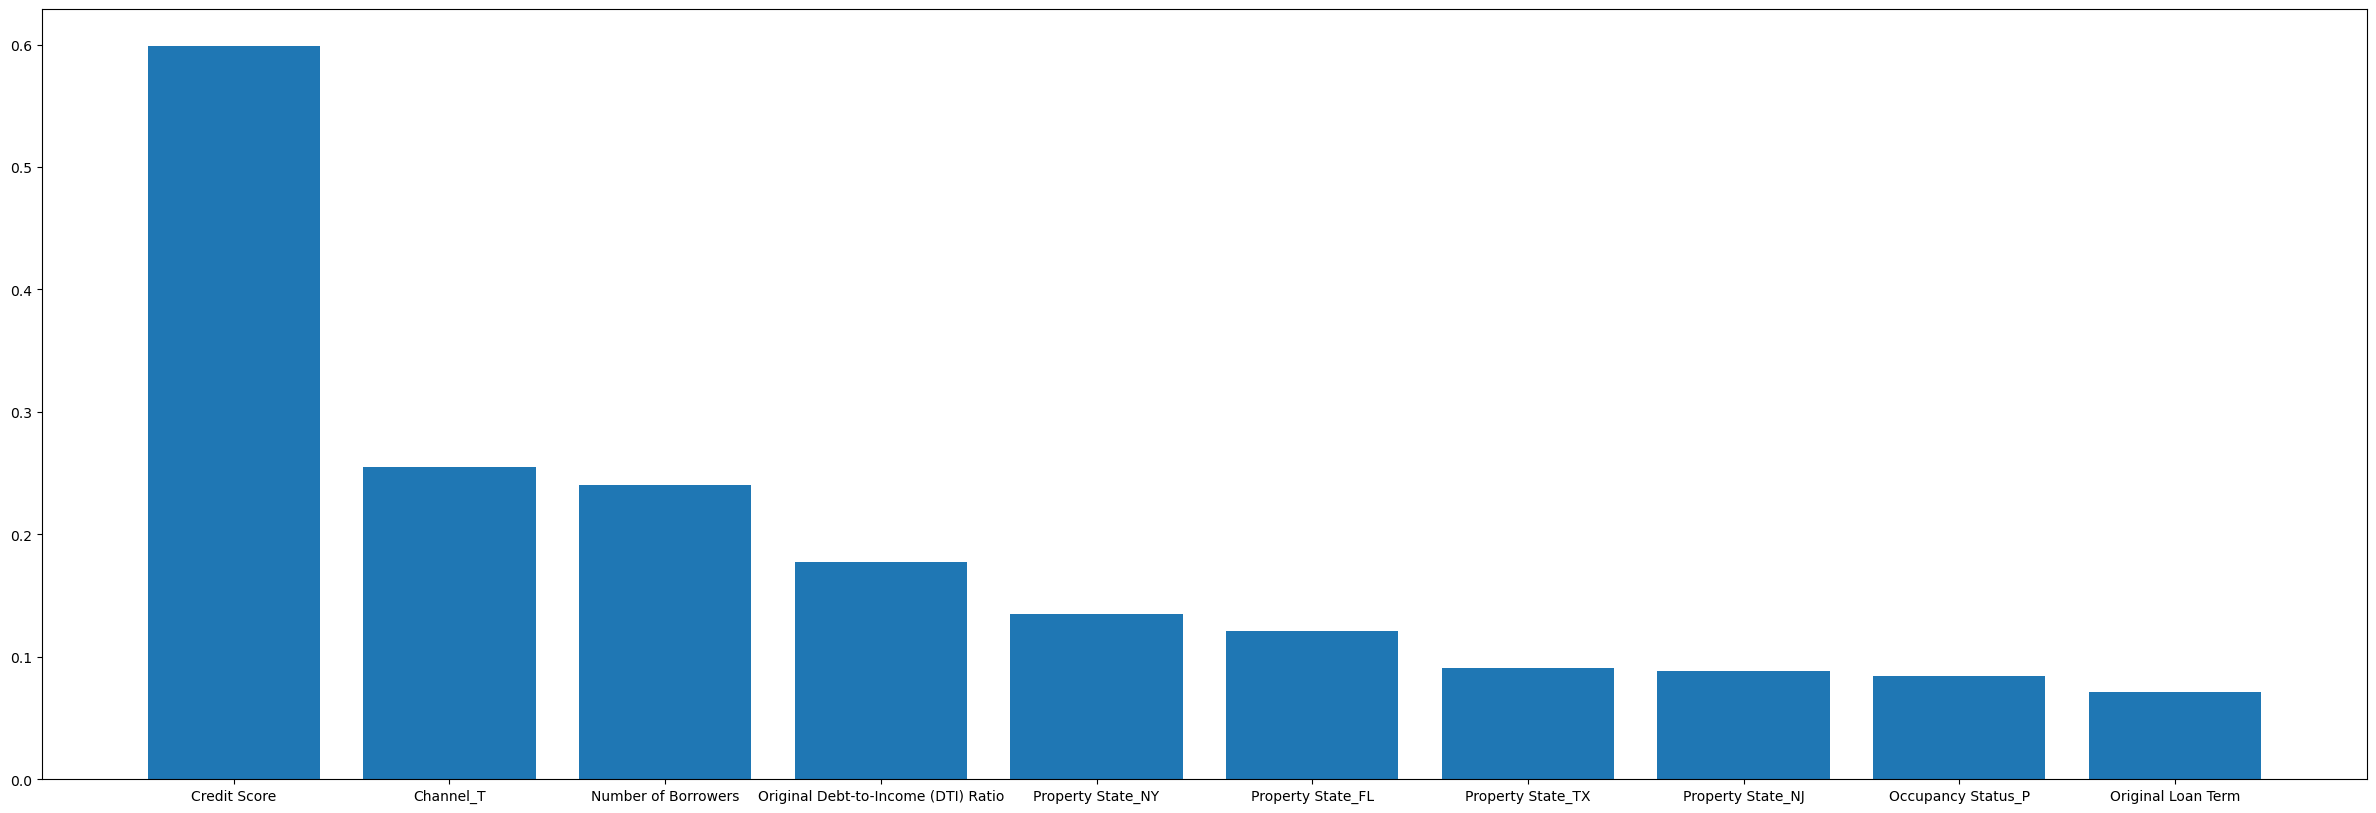

In [52]:
import matplotlib
matplotlib.rc('figure', figsize=(30, 10))

# setup the parameters
names = [name for imp, name in top_picks]
importance = [abs(imp) for imp, name in top_picks]  # take abs to make importance clear -> sign is not relevant

# plot the bar chart
plt.bar(names, height = importance)
plt.savefig('importance_bar_chart_lin_regr.png')
